In [86]:
# ID:sim_nn1
import numpy as np # We use numpy.
np.random.seed(15) # To make this reproducible.

# Generate fake-data (simulation) (start).
n = 1500 # number of observations.
hidden = 16 # number of hidden units for one hidden layer.
m = 1 # number of input columns.

betas_1 = np.random.normal(size=(m, hidden))
bias_1 = np.random.normal(size=hidden)

betas_2 = np.random.normal(size= (hidden, 1))
bias_2 = np.random.normal(size=1)

In [87]:
# ID:sim_nn2 (hide)
# random input matrix n x m.
xs = np.random.normal(size = (n, m))

# We walk through the layers and produces our final ys
ys = xs # Input
ys = np.matmul(ys, betas_1) + bias_1 # linear model.
ys = np.maximum(0, ys) # Non-linearity.
ys = np.matmul(ys, betas_2) + bias_2 # linear model.
ys = ys[:, 0] # Output

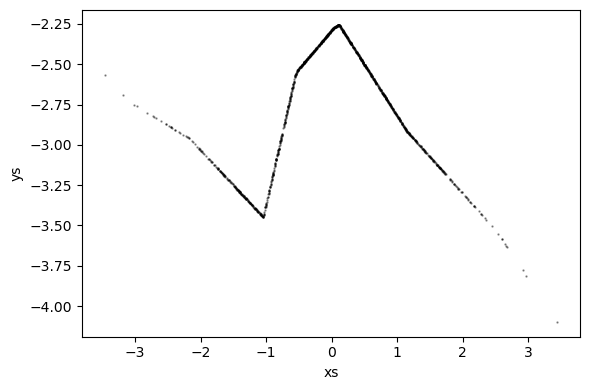

In [88]:
# OUT:sim_nn_out
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4)) # (hide)
ax.plot(xs, ys, marker='o', linestyle='', color='black', alpha = 0.4, markersize=0.7)
plt.xlabel('xs')
plt.ylabel('ys')
plt.tight_layout()
plt.show()

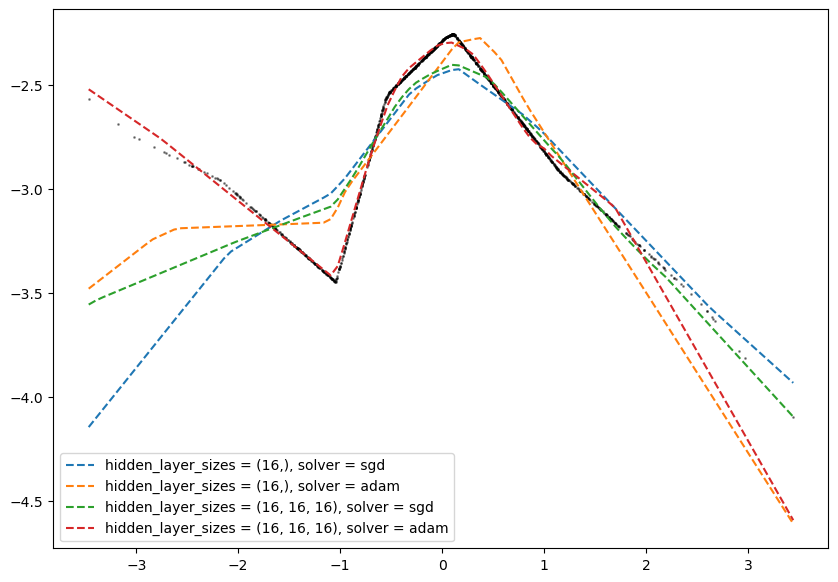

In [26]:
# ID:nn_sk OUT:nn_sk_out (hide)
# We use the scikit-learn library to implement the model.
from sklearn.neural_network import MLPRegressor
fig, ax = plt.subplots(figsize=(10,7)) # (hide)
ax.plot(xs, ys, marker='o', linestyle='', color='black', alpha = 0.4, markersize=1) # (hide)
xs_plot = np.linspace(min(xs), max(xs), 100)

# We explore two networks structures and two solvers.
for hidden_layer_sizes, solver in [((16,),'sgd'), ((16,),'adam'), ((16,16,16),'sgd'), ((16,16,16), "adam")]:
    
    model = MLPRegressor(random_state=1, hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver=solver, max_iter = 1000).fit(xs, ys)

    ys_plot = model.predict(xs_plot) 

    # Plotting this (end)
    ax.plot(xs_plot, ys_plot, label=f"hidden_layer_sizes = {hidden_layer_sizes}, solver = {solver}", linestyle='--')

ax.legend()
plt.show()

In [27]:
# ID:nn_tf1 (hide)
import tensorflow as tf # Using tensorflow core (hide).
# Initialize the parameters (here 'variables').
bias_1 = tf.Variable(np.random.normal(size=(hidden,), scale=0.1), dtype=tf.float32)
betas_1 = tf.Variable(np.random.normal(size=(m, hidden), scale=0.1), dtype=tf.float32)
bias_2 = tf.Variable(np.random.normal(size=(1,), scale=0.1), dtype=tf.float32)
betas_2 = tf.Variable(np.random.normal(size=(hidden, 1), scale=0.1), dtype=tf.float32)

xs_tf = tf.constant(xs, dtype=tf.float32) # to tensorflow
ys_tf = tf.constant(ys, dtype=tf.float32) # to tensorflow

In [28]:
# ID:nn_tf2 (hide)
# IMPORTANT. Run the previous cell before this one for initialization of the variables (hide)
for i in range(1000): # Minimize 1000 steps.
    with tf.GradientTape() as tp: # Recorde gradients...
        # Define the loss (error) function on our own.
        pred_ys_tf = xs_tf
        pred_ys_tf = tf.matmul(pred_ys_tf, betas_1) + bias_1
        pred_ys_tf = tf.nn.relu(pred_ys_tf)
        pred_ys_tf = tf.matmul(pred_ys_tf, betas_2) + bias_2
        pred_ys_tf = pred_ys_tf[:, 0]
        mean_square_error = tf.reduce_mean(tf.square(ys_tf - pred_ys_tf)) # Mean squared error.
    gradients = tp.gradient(mean_square_error, [bias_1, bias_2, betas_1, betas_2])
    bias_1.assign_sub(0.2 * gradients[0]) # learn rate ~ 0.2.
    bias_2.assign_sub(0.2 * gradients[1]) 
    betas_1.assign_sub(0.2 * gradients[2]) 
    betas_2.assign_sub(0.2 * gradients[3])

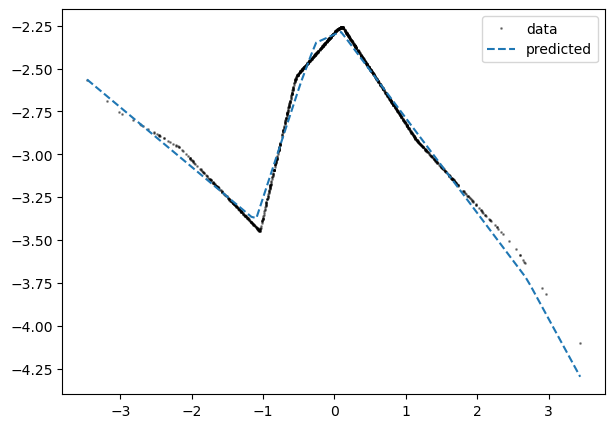

In [29]:
# OUT:nn_tf_out (hide)
fig, ax = plt.subplots(figsize=(7,5)) # (hide)
ax.plot(xs, ys, marker='o', linestyle='', color='black', alpha = 0.4, markersize=1, label = "data") # (hide)
xs_plot = np.linspace(min(xs), max(xs), 100)

xs_plot_tf = tf.constant(xs_plot, dtype=tf.float32)
ys_plot_tf = xs_plot_tf
ys_plot_tf = tf.matmul(ys_plot_tf[:, tf.newaxis], betas_1) + bias_1
ys_plot_tf = tf.nn.relu(ys_plot_tf)
ys_plot_tf = tf.matmul(ys_plot_tf, betas_2) + bias_2
ys_plot_tf = ys_plot_tf[:, 0]

# Plotting this (end)
ax.plot(xs_plot, ys_plot_tf.numpy(), label = "predicted", linestyle='--')

ax.legend()
plt.show()

In [30]:
# ID:nn_keras (hide)
import keras # Using keras API (on top of tensorflow).
import keras.layers as layers

# Single layer and a single output (a linear regression) (start).
model = keras.Sequential([
        layers.Dense(units=hidden, input_shape=[m], activation='relu'),
        layers.Dense(units=1, activation='linear')
])
# SGD.
optimizer = keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(xs, ys, epochs=100, verbose=0)

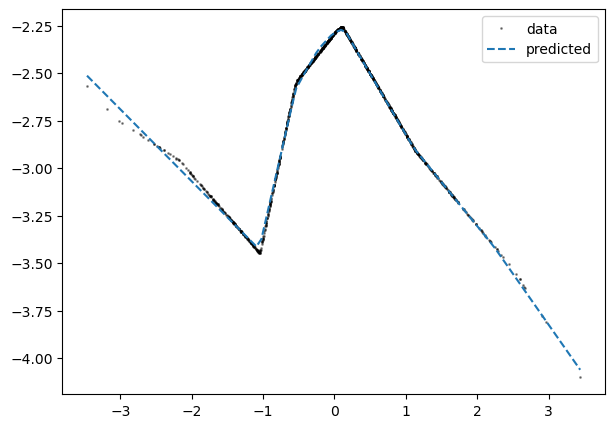

In [31]:
# OUT:nn_keras_out (hide)
fig, ax = plt.subplots(figsize=(7,5)) # (hide)
ax.plot(xs, ys, marker='o', linestyle='', color='black', alpha = 0.4, markersize=1, label = "data") # (hide)
xs_plot = np.linspace(min(xs), max(xs), 100)

ys_plot = model.predict(xs_plot, verbose=0)[:, 0]

ax.plot(xs_plot, ys_plot, linestyle='--', label='predicted')

plt.legend()
plt.show()

In [47]:
# This is highly forbidden. DON'T DO THIS AT HOME!
# ID:nn_stan1 (hide)
stan_code = """
data {
    int<lower=0> N; // number of observations.
    int<lower=0> M; // number of columns.
    int<lower=0> H; // number of hidden units.
    matrix[N, M] xs; // input values (matrix).
    vector[N] ys; // output values (array).
}   
parameters { // Parameters we search for.
    vector[H] bias_1;
    matrix[M, H] betas_1;
    real bias_2;
    matrix[H,1] betas_2;
}
"""

In [ ]:
# This is highly forbidden. DON'T DO THIS AT HOME!
# ID:nn_stan2 (hide)
stan_code += """
model { // Relationships between data and parameter.
    matrix[N, H] l1 = xs * betas_1;
    for (i in 1:N) l1[i] = to_row_vector(to_vector(l1[i]) + bias_1);
    matrix[N, H] l2 = inv_logit(l1); // Close to relu
    matrix[N, 1] l3 = l2 * betas_2;
    for(i in 1:N) l3[i] = l3[i] + bias_2;
    // Initialize the parameters (priors).
    to_vector(bias_1) ~ std_normal();
    to_vector(betas_1) ~ std_normal();
    to_vector(betas_2) ~ std_normal();
    bias_2 ~ normal(0, 1);
    
    ys ~ normal(to_vector(l3), 1); // Shit on sigma!
}
"""

In [62]:
import stan # Probabilistic programming language (STAN).

import nest_asyncio
nest_asyncio.apply()

# STAN WILL NOT LIKE THIS! IT IS NOT MADE FOR IT.
data = {'N': n, 'xs': xs, 'ys': ys, "H": 4, "M": m}
model = stan.build(stan_code, data=data)
posterior = model.sample(num_chains=1, num_samples=500)

Building...



Building: 40.8s, done.Sampling:   0%
Sampling:   0% (1/1500)Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/johannes/repos/presentations/2023_24_CSSE_blueprints/conda_env/lib/python3.11/concurrent/futures/process.py", line 261, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/johannes/repos/presentations/2023_24_CSSE_blueprints/conda_env/lib/python3.11/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]

Sampling:   7% (100/1500)
Sa

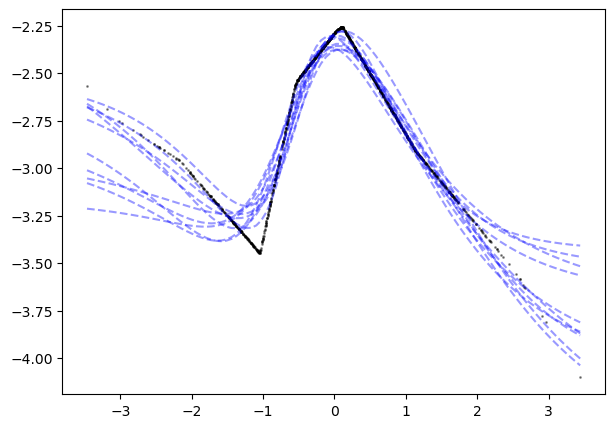

In [95]:
# OUT:nn_stan_out (hide)

fig, ax = plt.subplots(figsize=(7,5)) # (hide)
ax.plot(xs, ys, marker='o', linestyle='', color='black', alpha = 0.4, markersize=1, label = "data") # (hide)
xs_plot = np.linspace(min(xs), max(xs), 100)

for i in np.random.randint(0, 500, 10):
    # vector[H] bias_1;
    bias_1 = posterior["bias_1"][:,i]
    # matrix[M, H] betas_1;
    betas_1 = posterior["betas_1"][:,:,i]
    # real bias_2;
    bias_2 = posterior["bias_2"][:,i]
    # matrix[H,1] betas_2;
    betas_2 = posterior["betas_2"][:,:,i]

    ys_plot = xs_plot

    # We walk through the layers and produces our final ys
    ys_plot = np.matmul(ys_plot, betas_1) + bias_1 # linear model.
    ys_plot = 1.0 / (1 + np.exp(-ys_plot)) # Non-linearity.
    ys_plot = np.matmul(ys_plot, betas_2) + bias_2 # linear model.
    ys_plot = ys_plot[:, 0] # Output

    # # Plotting this (end)
    ax.plot(xs_plot, ys_plot, label = "predicted", linestyle='--', color = "blue",alpha = 0.4)

plt.show()